In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans




In [2]:
# Import libraries
from time import time
from joblib import Memory
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import nibabel as nib
import tempfile
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg
import os
import pywt


In [3]:
# Load data
segs = []
qsms = []
voxel_sizes = []
directory = 'D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/'
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    # Set aside test case
    if '47' not in filename:
        try:
            seg = nib.load(f+'/seg.nii')
        except:
            seg = nib.load(f+'/seg.nii.gz')
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())
        try:
            qsm = nib.load(f+'/qsm.nii')
        except:
            qsm = nib.load(f+'/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
    # Training cases
    else:
        try:
            seg_t = nib.load(f+'/seg.nii')
        except:
            seg_t = nib.load(f+'/seg.nii.gz')
        voxel_size_t = seg_t.header['pixdim'][0:3]
        try:
            qsm_t = nib.load(f+'/qsm.nii')
        except:
            qsm_t = nib.load(f+'/qsm.nii.gz')

n_cases = len(segs)
        

D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/047
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/050
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/045
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/034
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/046
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/043
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/052
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/044
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/049
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/035
D:/Elements Drive 2020/datasets/PD/12_28_2022/_QSM/051


In [4]:
# # Set window level
# level = 0
# window = 500
# m1=level-window/2
# m2=level+window/2
# # Apply window level
# y0 = qsm_t.get_fdata()
# y0[y0<m1]=m1
# y0[y0>m2]=m2

# # Single level Debauchies wavelet decomposition
# qsm_wtd = pywt.dwtn(y0, 'db1')
# fig,ax = plt.subplots(2,4)
# tracker = []
# i = 0
# for key, value in six.iteritems(qsm_wtd):
#     if i < (len(qsm_wtd)/2):
#         tracker.append(IndexTracker(ax[0,i], value,'hide_label'))
#     else: 
#         tracker.append(IndexTracker(ax[1,int(np.mod(i,(len(qsm_wtd)/2)))], value,'hide_label'))

#     fig.canvas.mpl_connect('scroll_event', tracker[i].onscroll)
#     i = i+1
# plt.tight_layout()
# plt.suptitle('Single level Debauchies wavelet decomposition');

In [5]:
# Generate feature structure Phi from all ROIs and all cases
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableFeatureClassByName('firstorder')
#extractor.enableAllImageTypes()
Phi = []
seg_t_sitk = sitk.GetImageFromArray(seg_t.get_fdata())
seg_t_sitk.SetSpacing(voxel_size_t.tolist())
qsm_t_sitk = sitk.GetImageFromArray(qsm_t.get_fdata())
qsm_t_sitk.SetSpacing(voxel_size_t.tolist())
# Create separate feature vector for test case
for j in range(1,int(np.max(segs[0]))+1):
    featureVector_t = extractor.execute(qsm_t_sitk,seg_t_sitk,label=j)

# Training cases
for i in range(n_cases):
    seg_sitk = sitk.GetImageFromArray(segs[i])
    seg_sitk.SetSpacing(voxel_sizes[i].tolist())
    qsm_sitk = sitk.GetImageFromArray(qsms[i])
    qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
    for j in range(1,int(np.max(segs[i]))+1):
        featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
        Phi.append(featureVector)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [6]:
# Extract numeric feature values
x_row = []
loop_count = 0
for i in range(n_cases):
    for j in range(int(np.max(segs[i]))):
        featureVector = Phi[j]
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row.append(value)
X0 = np.array(x_row)

# Test case
x_row_t = []
for j in range(int(np.max(segs[0]))):
        featureVector = featureVector_t
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row_t.append(value)
X0_t = np.array(x_row_t)

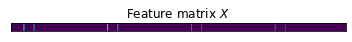

In [7]:
# Visualize feature matrix X
X = X0.reshape((n_cases,int(len(X0)/n_cases)))
fig,ax = plt.subplots(1,1)
plt.style.use('dark_background')
plt.imshow(X)
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');
# Normalize testing and training cases together
#   Otherwise the scale during clf.predict() is wrong
scaler = StandardScaler()
# What are the default parameters for this scaling?
X_all = np.vstack((X,X0_t))
X_all_t = scaler.fit_transform(X_all)
X_t = X_all_t[X.shape[0]:,:]
X = X_all_t[:X.shape[0]]

In [8]:
# UPDRS targets
#   Must be ordered according to list-generating loop
#   Larger data arrays will need a text file in each directory
#   So targets and inputs can be read simultaneously

u = np.array([[0,0,0,0],
[0,0,0,0],
[3,8,32,4],
[1,3,18,2],
[0,0,0,0],
[0,0,0,0],
[3,10,24,2],
[0,0,0,0],
[0,0,0,0],
[0,0,0,0]])


In [9]:
# Cross-validation for model selection
cv = KFold(3)
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)
# Lasso loss function
#   If fit_intercept=False, predictions are negative...odd
#   None of the training data is negative, does this indicate a problem?
#   Set upper and lower limits based on UPDRS?
alphas = ((1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3))
lasso = Lasso(alpha=0.1,fit_intercept=False,max_iter=10000,tol=0.0001)
ward = FeatureAgglomeration(n_clusters=100, linkage="ward",memory=mem)

clf = Pipeline([("ward", ward), ("Lasso", lasso)])
# # Select the optimal number of clusters with grid search
clf = GridSearchCV(clf, {"Lasso__alpha" : alphas, "ward__n_clusters": [5,10,25,100,1000]}, n_jobs=1, cv=cv, scoring='r2')
clf.fit(X,u)  

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.316228, ..., -0.316228],
       ...,
       [ 0.316228, ...,  0.316228]]), connectivity=None, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.316228, ..., -0.316228],
       ...,
       [ 0.316228, ...,  0.316228]]), connectivity=None, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.316228, ..., -0.316228],
       ...,
       [ 0.316228, ...,  0.316228]]), connec

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\pipeline.py", line 355, in _fit
    **fit_params_steps[name

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ward',
                                        FeatureAgglomeration(memory=Memory(location=C:\Users\agr78\AppData\Local\Temp\tmpw82we1ke\joblib),
                                                             n_clusters=100)),
                                       ('Lasso',
                                        Lasso(alpha=0.1, fit_intercept=False,
                                              max_iter=10000))]),
             n_jobs=1,
             param_grid={'Lasso__alpha': (0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                          1000.0),
                         'ward__n_clusters': [5, 10, 25, 100, 1000]},
             scoring='r2')

In [10]:
X.shape

(10, 428)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


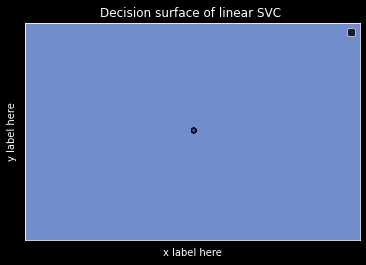

In [58]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

clf = svm.SVC(C=0.1, kernel='sigmoid')
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:,30], X[:,1]
clf.fit(X[:,:2],u[:,1])  
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=u[:,1].ravel(), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [52]:
X[:,:2].shape

(10, 2)

In [34]:
u.ravel().shape

(40,)

In [35]:
X.ravel().shape

(4280,)

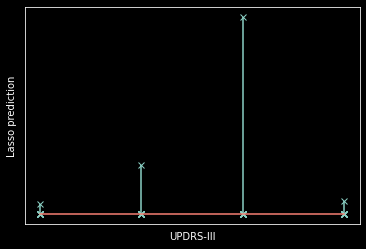

In [11]:

fig,ax = plt.subplots(1,1)

lasso = Lasso(alpha=0.1,fit_intercept=False,max_iter=10000,tol=0.0001)
lasso.fit(X,u)
plt.stem(
    np.where(lasso.coef_)[0],
    abs(lasso.coef_[lasso.coef_ != 0]),
    markerfmt="x",
    label="Lasso coefficients")
plt.xlabel('UPDRS-III')
plt.xticks([])
plt.ylabel('Lasso prediction')
plt.yticks([])
plt.show()


In [12]:
lasso.coef_

array([[-1.21359436e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.64078309e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.24008547e+01, -0.00000000e+00, -1.77635684e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.52982213e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Ward clustering found 5 distinctive features


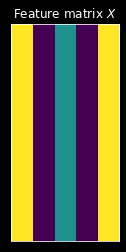

In [13]:
# Plot clustered feature matrix
ward = FeatureAgglomeration(n_clusters=clf.best_estimator_['ward'].n_clusters, linkage="ward",memory=mem)
Xw = ward.fit_transform(X,u)
print('Ward clustering found '+str(Xw.shape[1])+ ' distinctive features')
fig,ax = plt.subplots(1,1)
plt.style.use('dark_background')
plt.imshow(Xw)
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');

In [14]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('ward',
   FeatureAgglomeration(memory=Memory(location=C:\Users\agr78\AppData\Local\Temp\tmpw82we1ke\joblib),
                        n_clusters=5)),
  ('Lasso', Lasso(alpha=10.0, fit_intercept=False, max_iter=10000))],
 'verbose': False,
 'ward': FeatureAgglomeration(memory=Memory(location=C:\Users\agr78\AppData\Local\Temp\tmpw82we1ke\joblib),
                      n_clusters=5),
 'Lasso': Lasso(alpha=10.0, fit_intercept=False, max_iter=10000),
 'ward__affinity': 'euclidean',
 'ward__compute_distances': False,
 'ward__compute_full_tree': 'auto',
 'ward__connectivity': None,
 'ward__distance_threshold': None,
 'ward__linkage': 'ward',
 'ward__memory': Memory(location=C:\Users\agr78\AppData\Local\Temp\tmpw82we1ke\joblib),
 'ward__n_clusters': 5,
 'ward__pooling_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'Lasso__alpha': 10.0,
 'Lasso__copy_X': True,
 'Lasso__fit_intercept': False,
 'Lasso__max_

In [15]:
# Set best parameters from cross-validation
# Ward-Lasso w* of length reduced number of features in Xw
coef_lasso = clf.best_estimator_.steps[-1][1].coef_
# Lasso w* of length of original number of features in X
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_lasso)
# Summary feature dimensionality reduction and selection
print("From original " +str(X.shape[1])+" features,"+" Ward clustering and LASSO cross-validation found " + str(np.count_nonzero(coef_)) + " features that should have nonzero weights")
# Predict test case
clf.best_estimator_.predict(X_t)

From original 428 features, Ward clustering and LASSO cross-validation found 0 features that should have nonzero weights


array([[0., 0., 0., 0.]])

In [16]:
lasso_c = Lasso(alpha=0.1,fit_intercept=False,max_iter=10000,tol=0.0001)

In [17]:
# Test impact of Ward feature dimensionality reduction and cross-validation
# Makes sense that there is no impact on overall estimator because
# Dataset is not homogenously PD patients so cross-validation assumption of iid data fails
ovr = OneVsRestClassifier(clf.best_estimator_)
ovr_c = OneVsRestClassifier(lasso_c)


In [18]:
# fit model
ut = []
for k in range(u.shape[1]):
    ovr.fit(X,u[:,k])
    # make predictions
    ut.append(ovr.predict(X_t))

In [19]:
ut0 = (2,13,30,6)


In [20]:
ut

[array([3]), array([10]), array([32]), array([4])]